In [1]:
# Processing/Misc

from sklearn.utils import shuffle

import numpy as np
import os

import matplotlib.pyplot as plt

In [2]:
# Keras

import keras.backend as K
from keras import regularizers
from keras import optimizers
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout, Flatten, Conv1D, BatchNormalization, Activation, GlobalMaxPooling1D, MaxPooling1D, TimeDistributed

Using TensorFlow backend.


In [3]:
# Hyperz

epochs           = 500
batch_size       = 64

window_size      = 90
skip_window_size = 8

train_split      = .9
emb_size         = 5

In [4]:
# Load Data

def create_timeframed_alldata_data(stocks, window_size=10, skip_window_size=2):
    """
    Timeframe Alldata
    """
    X, Y = [], []
    
    for stock in stocks:
        
        ### Load From File
        
        raw_data = []
        
        with open(os.path.join('..', 'data', stock + '.csv'), 'r') as data:

            for line in data:

                if len(line) > 6 and "Date" not in line and "null" not in line:

                    items = line.split(",")
                    items = np.array(list(map(float, items[1:])))

                    raw_data.append(np.take(items, [0, 1, 2, 4, 5])) # OPEN HIGH LOW ADJ_CLOSE VOLUME
        
        data = np.array(raw_data)
        
        ### Process
        
        for i in range(1, len(data) - window_size - 1):

            time_frame = np.copy(data[i: i + window_size + 1])
            
            trainable_frame = time_frame[:-skip_window_size-1]

            target_close = time_frame[-1, 3]
            last_close = trainable_frame[-1, 3]

            time_frame -= np.mean(trainable_frame, axis=0)
            time_frame /= (np.std(trainable_frame, axis=0) + 1e-7)

            X.append(trainable_frame)

            if last_close < target_close:

                Y.append([1.])

            else:

                Y.append([0.])
                
            Y[-1].append(time_frame[-1, 3] - time_frame[0, 3])
        
    return np.array(X), np.array(Y)


In [5]:
# Split

def split_data(X, Y, ratio=.8, mix=True):
    """
    Splits X/Y to Train/Test
    """
    train_size = int(len(X) * ratio)
    
    trainX, testX = X[:train_size], X[train_size:]
    trainY, testY = Y[:train_size], Y[train_size:]
    
    if mix:
        
        trainX, trainY = shuffle(trainX, trainY, random_state=0)
    
    return trainX, trainY, testX, testY

def get_data(stocks):
    
    X, Y = create_timeframed_alldata_data(stocks, window_size=window_size, skip_window_size=skip_window_size)
    
    return split_data(X, Y, ratio=train_split)


In [6]:
# Model

def binacc(y_true, y_pred):
    return K.mean(K.equal(y_true[:, 0], K.round(y_pred[:, 0])), axis=-1)

def get_model():
    
    model = Sequential()

    model.add(LSTM(200, input_shape=(window_size - skip_window_size, emb_size)))
    
    model.add(Dense(200))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    model.add(Dense(100))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    model.add(Dense(80))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))

    model.add(Dense(2))
    
    model.compile(loss='mse', optimizer='adam', metrics=[binacc])
        
    return model


In [7]:
# Load Data

if __name__ == "__main__":
    
    trainX, trainY, testX, testY = get_data(['AAPL', 'GOOG', 'MSFT'])
    
    print(trainX.shape, trainY.shape)


(18270, 82, 5) (18270, 2)


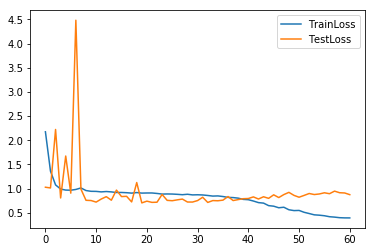

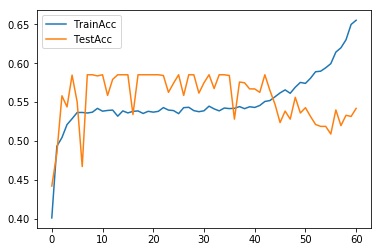

In [8]:
# Train

if __name__ == "__main__":

    model = get_model()

    reduce_LR = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=1e-6, verbose=0)
    e_stopping = EarlyStopping(patience=40)
    checkpoint = ModelCheckpoint(os.path.join('..', 'models', 'trend-pred.h5'), 
                                 monitor='val_loss', 
                                 verbose=0, 
                                 save_best_only=True)

    history = model.fit(trainX, trainY, epochs=epochs, 
                                        batch_size=batch_size, 
                                        validation_data=(testX, testY), 
                                        verbose=0, 
                                        callbacks=[e_stopping, checkpoint])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['TrainLoss', 'TestLoss'])
    plt.show()

    plt.plot(history.history['binacc'])
    plt.plot(history.history['val_binacc'])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
